In [9]:
from attention import AttentionLayer

In [10]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
file_path='/content/Reviews.csv'
data=pd.read_csv(file_path,nrows=100000)

In [13]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6239 entries, 0 to 6261
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      6239 non-null   int64 
 1   ProductId               6239 non-null   object
 2   UserId                  6239 non-null   object
 3   ProfileName             6239 non-null   object
 4   HelpfulnessNumerator    6239 non-null   int64 
 5   HelpfulnessDenominator  6239 non-null   int64 
 6   Score                   6239 non-null   int64 
 7   Time                    6239 non-null   int64 
 8   Summary                 6239 non-null   object
 9   Text                    6239 non-null   object
dtypes: int64(5), object(5)
memory usage: 536.2+ KB


In [15]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [16]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [18]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [19]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [20]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [21]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [22]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [23]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

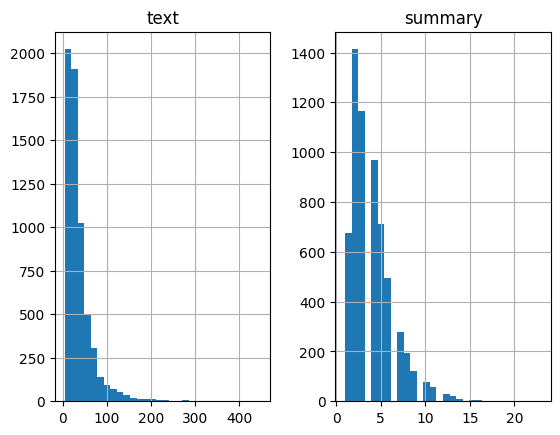

In [24]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [25]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9459416105229387


In [26]:
max_text_len=30
max_summary_len=8

In [27]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [28]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [29]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [30]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [31]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 68.99458157736304
Total Coverage of rare words: 11.155976600921468


In [32]:

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

x_voc   =  x_tokenizer.num_words + 1

In [33]:
x_voc

2061

In [34]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [35]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 86.26400389673648
Total Coverage of rare words: 17.424469938134422


In [36]:

y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

y_voc  =   y_tokenizer.num_words +1

In [37]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(3197, 3197)

In [38]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [39]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [40]:
from keras import backend as K
K.clear_session()

latent_dim = 300
embedding_dim=100

encoder_inputs = Input(shape=(max_text_len,))

enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 100)              206100    ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 30, 300),            481200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [42]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [43]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=5,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/5
23/23 [==============================] - 31s 577ms/step - loss: 3.0659 - val_loss: 2.3485
Epoch 2/5
23/23 [==============================] - 12s 509ms/step - loss: 2.3334 - val_loss: 2.2974
Epoch 3/5
23/23 [==============================] - 13s 568ms/step - loss: 2.2653 - val_loss: 2.1418
Epoch 4/5
23/23 [==============================] - 9s 417ms/step - loss: 2.1168 - val_loss: 2.0218
Epoch 5/5
23/23 [==============================] - 9s 400ms/step - loss: 2.0234 - val_loss: 1.9677


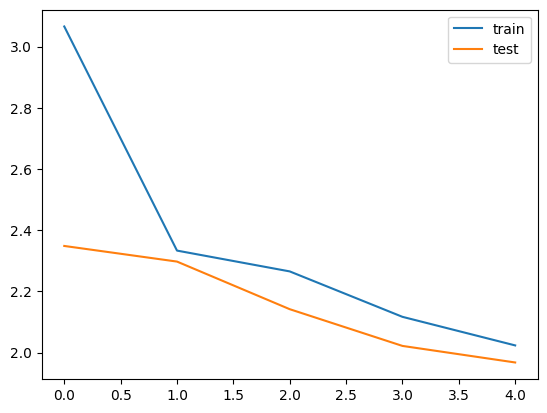

In [44]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [45]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [46]:

encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat)

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [47]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1))

    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

In [48]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [49]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: jar much smaller via thought going size jar instead much smaller spicy though lots jalapeno lot honey mustard 
Original summary: small but spicy 
1/1 [==============================] - 0s 19ms/step
Predicted summary:  great


Review: never let tastes fresh strong smell argentina every sip going increase prices almost double crazy worth value never change 
Original summary: good 
1/1 [==============================] - 0s 25ms/step
Predicted summary:  great


Review: used product cake wedding cake made worked well happy got non stop 
Original summary: awesome product 
1/1 [==============================] - 0s 19ms/step
Predicted summary:  great


Review: someone goes lots thyme pleasantly surprised see product amazon reasonable price looks smells tastes like thyme beat running grocery store paying tiny bottle would last maybe weeks house 
Original summary: and delicious 
1/1 [==============================] - 0s 19ms/step
Predicted summary:  great


Review: cant find flavor store

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Create GUI components
text_input = widgets.Textarea(placeholder='Enter text here...')
algorithm_dropdown = widgets.Dropdown(options=['Seq2Seq', 'TextRank', 'Attention'], description='Algorithm:')
summarize_button = widgets.Button(description='Summarize')
output_area = widgets.Output()

# Define event handler for button click
def on_summarize_button_clicked(b):
    with output_area:
        output_area.clear_output()
        algorithm = algorithm_dropdown.value
        text = text_input.value
        if algorithm == 'Seq2Seq':
            # Call seq2seq summarization function
            pass
        elif algorithm == 'TextRank':
            # Call TextRank summarization function
            pass
        elif algorithm == 'Attention':
            # Call attention-based summarization function
            pass

summarize_button.on_click(on_summarize_button_clicked)

# Display GUI
display(text_input, algorithm_dropdown, summarize_button, output_area)


Textarea(value='', placeholder='Enter text here...')

Dropdown(description='Algorithm:', options=('Seq2Seq', 'TextRank', 'Attention'), value='Seq2Seq')

Button(description='Summarize', style=ButtonStyle())

Output()

In [ ]:
!pip install transformers
!pip install nltk

import nltk
nltk.download('punkt')

import pandas as pd
from transformers import pipeline

# Download the Amazon food reviews dataset
!wget -O Reviews.csv "https://drive.google.com/uc?export=download&id=1heJvA7VD5RBWTXhycQ5y5dMLCIpu7XoJ"


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


--2024-05-06 19:19:34--  https://drive.google.com/uc?export=download&id=1heJvA7VD5RBWTXhycQ5y5dMLCIpu7XoJ
Resolving drive.google.com (drive.google.com)... 142.250.128.101, 142.250.128.100, 142.250.128.113, ...
Connecting to drive.google.com (drive.google.com)|142.250.128.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1heJvA7VD5RBWTXhycQ5y5dMLCIpu7XoJ&export=download [following]
--2024-05-06 19:19:34--  https://drive.usercontent.google.com/download?id=1heJvA7VD5RBWTXhycQ5y5dMLCIpu7XoJ&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.183.132, 2607:f8b0:4001:c64::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.183.132|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-05-06 19:19:35 ERROR 404: Not Found.



In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
from nltk.tokenize import sent_tokenize
import heapq
import re

def seq2seq_summarization(text):
    # Load pre-trained T5 model and tokenizer
    model = T5ForConditionalGeneration.from_pretrained("t5-small")
    tokenizer = T5Tokenizer.from_pretrained("t5-small")

    # Preprocess the text
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True)

    # Generate summary
    summary_ids = model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

def textrank_summarization(text):
    # Tokenize text into sentences
    sentences = sent_tokenize(text)

    # Compute word frequencies
    word_frequencies = {}
    for sentence in sentences:
        words = re.findall(r'\b\w+\b', sentence.lower())
        for word in words:
            if word not in word_frequencies:
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1

    # Normalize word frequencies
    maximum_frequency = max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word] = word_frequencies[word] / maximum_frequency

    # Compute sentence scores
    sentence_scores = {}
    for sentence in sentences:
        for word in nltk.word_tokenize(sentence.lower()):
            if word in word_frequencies.keys():
                if len(sentence.split(' ')) < 30:
                    if sentence not in sentence_scores.keys():
                        sentence_scores[sentence] = word_frequencies[word]
                    else:
                        sentence_scores[sentence] += word_frequencies[word]

    # Get the top N sentences
    summary_sentences = heapq.nlargest(3, sentence_scores, key=sentence_scores.get)
    summary = ' '.join(summary_sentences)

    return summary


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load the dataset
file_path='/content/drive/MyDrive/Reviews.csv'
df = pd.read_csv(file_path)

# Create GUI components
text_input = widgets.Textarea(placeholder='Enter text here...')
algorithm_dropdown = widgets.Dropdown(options=['Seq2Seq', 'TextRank'], description='Algorithm:')
summarize_button = widgets.Button(description='Summarize')
output_area = widgets.Output()

# Define event handler for button click
def on_summarize_button_clicked(b):
    with output_area:
        clear_output()
        algorithm = algorithm_dropdown.value
        text = text_input.value
        if algorithm == 'Seq2Seq':
            summary = seq2seq_summarization(text)
        elif algorithm == 'TextRank':
            summary = textrank_summarization(text)
        print("Summary:")
        print(summary)

summarize_button.on_click(on_summarize_button_clicked)

# Display GUI
display(text_input, algorithm_dropdown, summarize_button, output_area)


Textarea(value='', placeholder='Enter text here...')

Dropdown(description='Algorithm:', options=('Seq2Seq', 'TextRank'), value='Seq2Seq')

Button(description='Summarize', style=ButtonStyle())

Output()

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load the dataset
file_path='/content/drive/MyDrive/Reviews.csv'
df = pd.read_csv(file_path)

# Example review
example_review = """
I bought these chips yesterday and I must say they are amazing. The flavor is delicious and the texture is perfect.
They are not too salty and have just the right amount of crunch. I will definitely be buying these again!
"""

# Create GUI components
text_input = widgets.Textarea(placeholder='Enter text here...', value=example_review)
algorithm_dropdown = widgets.Dropdown(options=['Seq2Seq', 'TextRank'], description='Algorithm:')
summarize_button = widgets.Button(description='Summarize')
output_area = widgets.Output()

# Define event handler for button click
def on_summarize_button_clicked(b):
    with output_area:
        clear_output()
        algorithm = algorithm_dropdown.value
        text = text_input.value
        if algorithm == 'Seq2Seq':
            summary = seq2seq_summarization(text)
        elif algorithm == 'TextRank':
            summary = textrank_summarization(text)
        print("Summary:")
        print(summary)

summarize_button.on_click(on_summarize_button_clicked)

# Display GUI
display(text_input, algorithm_dropdown, summarize_button, output_area)


Textarea(value='\nI bought these chips yesterday and I must say they are amazing. The flavor is delicious and …

Dropdown(description='Algorithm:', options=('Seq2Seq', 'TextRank'), value='Seq2Seq')

Button(description='Summarize', style=ButtonStyle())

Output()

In [ ]:
!pip install pyngrok
